# Solution - Assessment 3

## DRW & UofC Quant Foundations
### Summer 2023
#### Mark Hendricks
#### hendricks@uchicago.edu

# 1. OLS (35 pts)

Consider decomposing the returns of inflation-indexed bonds (ticker, ”TIP”) with OLS regression estimates.

$$\newcommand{\targ}{\text{HYG}}$$
$$\newcommand{\dep}{\text{IEF}}$$
$$\newcommand{\depsec}{\text{SPY}}$$

### 1.1 

Use OLS to estimate the regression of $\targ$ on $\dep$.

$$r^{\targ}_t = \alpha + \beta^{\dep}r^{\dep}_t + \epsilon_t$$

* (a) (5pts) Report the estimate for $\beta^{\dep}$ and the r-squared.

* (b) (5pts) Based on this estimation, explain whether $\targ$ returns are sensitive to $\dep$, both in the sense of having an impact and as to whether they explain most time- series variation in real estate returns.

### 1.2. 

(5pts) Consider a multivariable regression of $\targ$ on both $\dep$ and $\depsec$.

$$r^{\targ}_t = \alpha + \beta^{\dep}r_t^{\dep} + \beta^{\depsec}r_t^{\depsec} + \epsilon$$

Report the estimate for $\beta^{\dep}$ and the r-squared.

### 1.3. 

* (a) (5pts) Report the correlation matrix of $\targ, \dep, \depsec$.
* (b) (5pts) Discuss why the estimated $\beta^{\dep}$ changed from the univariate regression versus the multivariate regression.

### 1.4. 
(10pts) No need to report the t-stats from the two regression estimates above. But name two assumptions on which the classical t-stats depend. Comment on whether those assumptions are reasonable in these regressions.

***

# <span style='color:red'>Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import random

import warnings

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 

In [3]:
DATAFILE = '../data/exam_3_data.xlsx'

In [4]:
rets = pd.read_excel(DATAFILE,sheet_name='returns').set_index('date')
rets

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
date,,,,,,,,,,,
2009-04-30,0.099346,0.115190,0.155582,0.230202,0.022882,0.138460,-0.001000,0.296151,-0.027453,0.008993,-0.017951
2009-05-31,0.058454,0.131918,0.159400,0.053892,0.027865,0.028555,0.162663,0.022727,-0.020772,0.053672,0.019967
2009-06-30,-0.000655,-0.014049,-0.022495,0.045449,-0.003436,0.033517,-0.026259,-0.024863,-0.005572,0.005150,0.001982
2009-07-31,0.074606,0.100415,0.110146,0.143247,0.015326,0.069190,0.018568,0.105799,0.008317,0.031284,0.000879
2009-08-31,0.036939,0.045031,-0.013136,0.033412,-0.004151,-0.016970,-0.040365,0.131939,0.007635,0.007628,0.008414
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,0.062887,0.090037,0.091293,0.133475,0.029164,0.036670,0.008925,0.099774,0.035811,0.035666,0.020763
2023-02-28,-0.025143,-0.030748,-0.075677,-0.006542,-0.008535,-0.018852,-0.044632,-0.059618,-0.032708,-0.046942,-0.013530
2023-03-31,0.037078,0.031291,0.032174,-0.048918,0.005854,0.019843,-0.000842,-0.019370,0.037211,0.047101,0.028643


In [5]:
def estimate_reg(X,y,model=LinearRegression,penalty=None,DoIntercept=True):
    if model is LinearRegression:
        mod = LinearRegression(fit_intercept=DoIntercept).fit(X,y)
    else:
        mod = model(alpha=penalty, fit_intercept=DoIntercept).fit(X,y)
    
    estimates = pd.Series(index = list(X.columns) + ['r-squared'], dtype=float)
    estimates.loc[X.columns] = mod.coef_
    
#    if DoIntercept:
#        estimates = pd.concat([pd.Series(index=['intercept'], data=mod.intercept_), estimates]) 
    estimates.loc['r-squared'] = mod.score(X,y)
    
    return estimates

### <span style='color:red'>1.1 & 1.2</span>

In [6]:
TARGET = 'HYG'
REG_UNI = 'IEF'
REG_MULTI = [REG_UNI,'SPY']

y = rets[TARGET]
x = rets[[REG_UNI]]
X = rets[REG_MULTI]
Xall = rets.drop(columns=[TARGET])

#### <span style='color:red'>(a)</span>

In [7]:
ols = pd.DataFrame(columns=['uni','multi'], index=list(X.columns)+['r-squared'], dtype=float)
ols['uni'] = estimate_reg(x,y)
ols['multi'] = estimate_reg(X,y)

ols.style.format('{:.1%}')

,uni,multi
IEF,-0.5%,16.5%
SPY,nan%,47.8%
r-squared,0.0%,60.6%


#### <span style='color:red'>(b)</span>

From the OLS model, we see that bond returns (IEF) have almost no linear relation to high-yield bond returns (HYG) in a univariate model. The r-squared is nearly zero, and the estimated beta is also nearly zoer.

Once we include SPY, the model is more interesting. R-squared is 60%, so there is substantial covariation between HYG and SPY. Furthermore, in the multivariate framework there is some postive association between HYG and IEF, (beta of roughly .165.) 

To further assess this association, or at least our confidence in the discovery, we could look at the t-statistics.

### <span style='color:red'>1.3</span>

#### <span style='color:red'>(a)</span>

In [8]:
pd.concat([X, y], axis=1).corr().style.format('{:.1%}')

,IEF,SPY,HYG
IEF,100.0%,-15.2%,-0.3%
SPY,-15.2%,100.0%,77.0%
HYG,-0.3%,77.0%,100.0%


#### <span style='color:red'>(b)</span>

The correlation matrix above shows a negative correlation between IEF and SPY, which reflects the positive shift in $\beta^{IEF}$ after including SPY in the regression. In the univariate regression, $\beta^{IEF}$ was negative, as IEF has a negative correlation to HYG. However, it is also negatively correlated to SPY, which itself has a positive relationship with HYG. As a result, when we include SPY in our regression, IEF no longer needs to explain SPY's association with HYG which leads to the shift in $\beta^{IEF}$.

### <span style='color:red'>1.4</span>
Some important classical t-stats assumptions include:
1) Homoskedasticity
2) No serial correlation
3) Normally distributed residuals

These are not obviously violated here. The regression involves returns, which have low serial correlation. Even if the data isn't close to being normally distributed, we have a large enough sample to rely on the CLT.

This was not required, but we can briefly visualize some of these assumptions with plots such as the ones below.

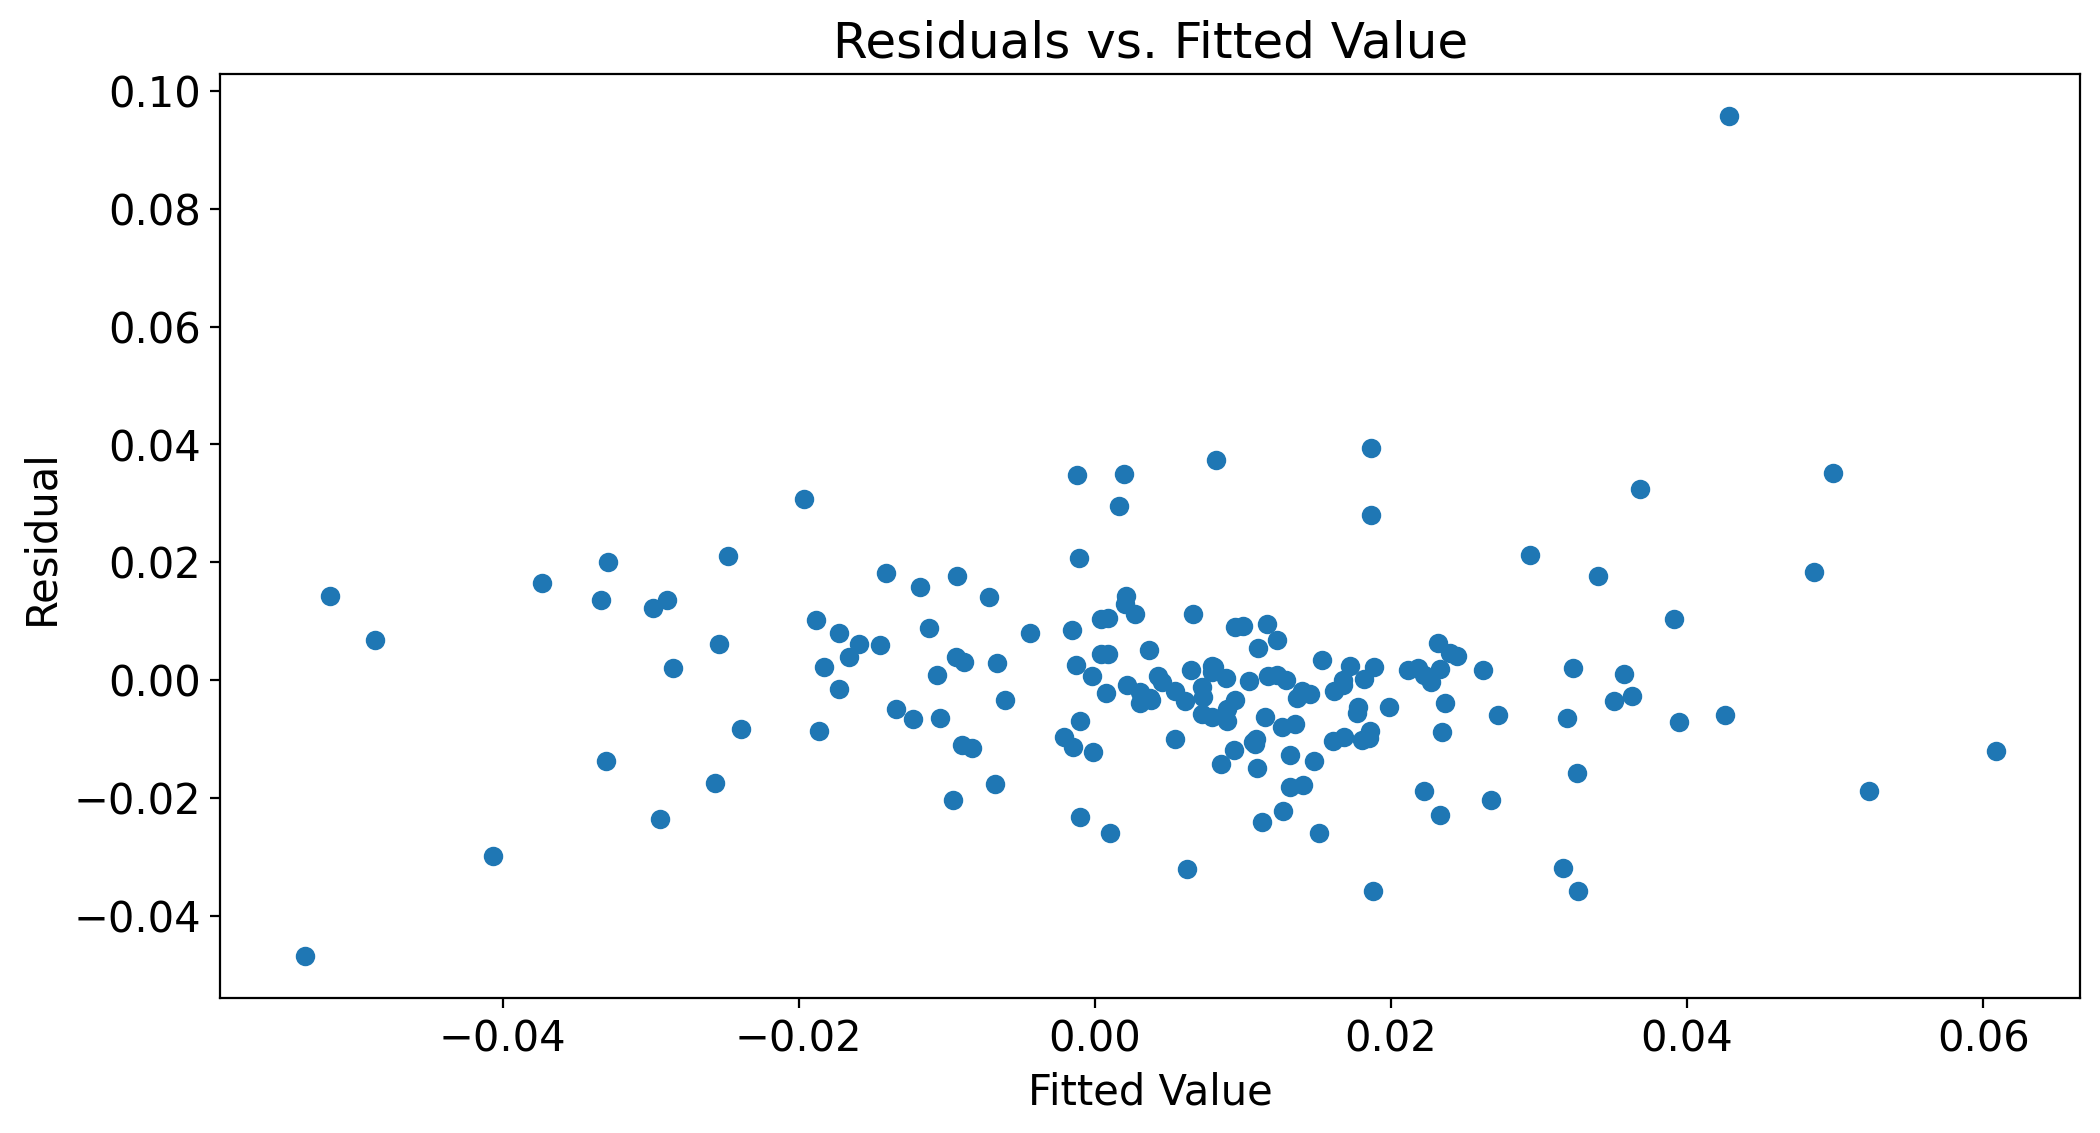

In [9]:
model = sm.OLS(y, X).fit()

plt.scatter(x=model.fittedvalues, y=model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residuals vs. Fitted Value')
plt.show()

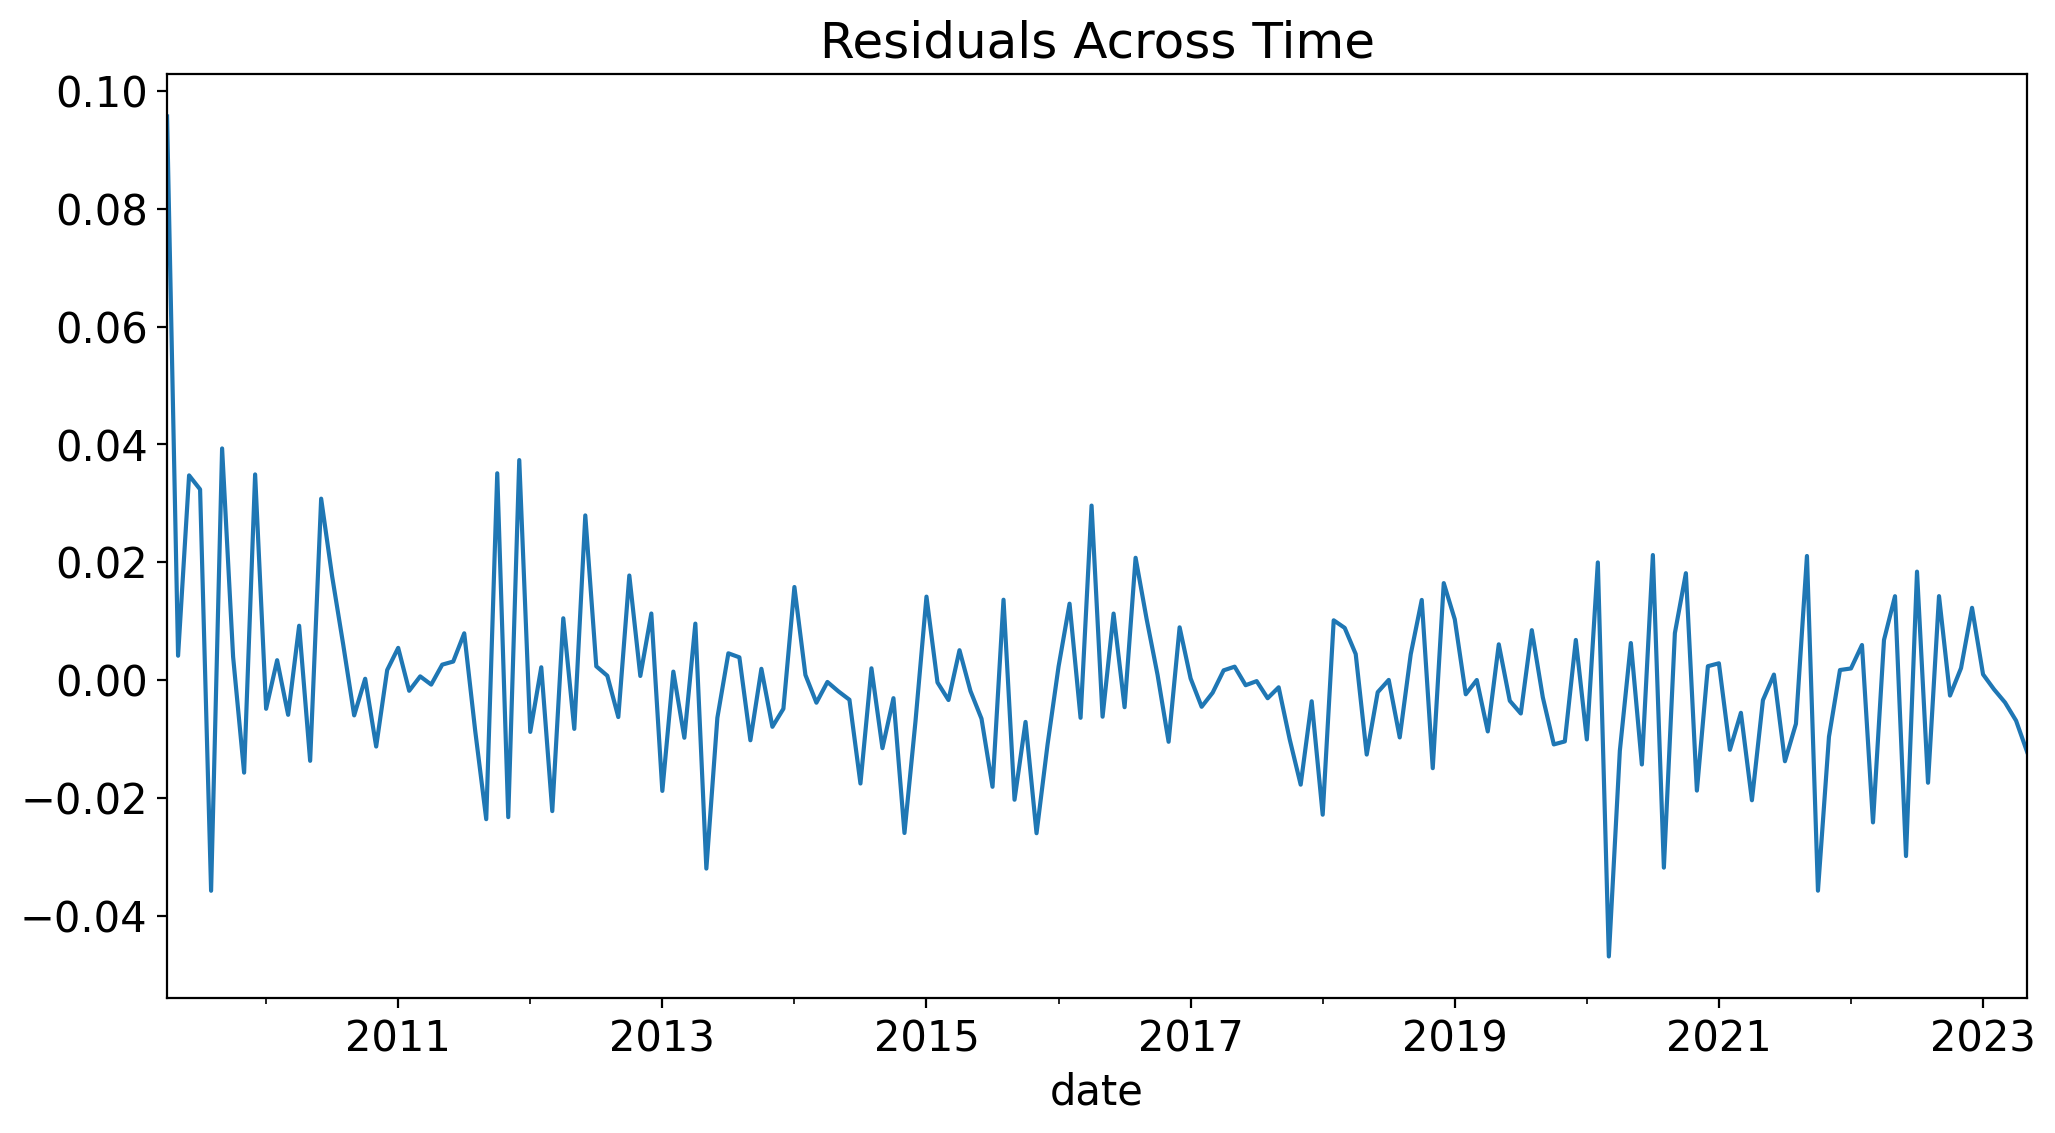

In [10]:
model.resid.plot(title='Residuals Across Time')
plt.show()

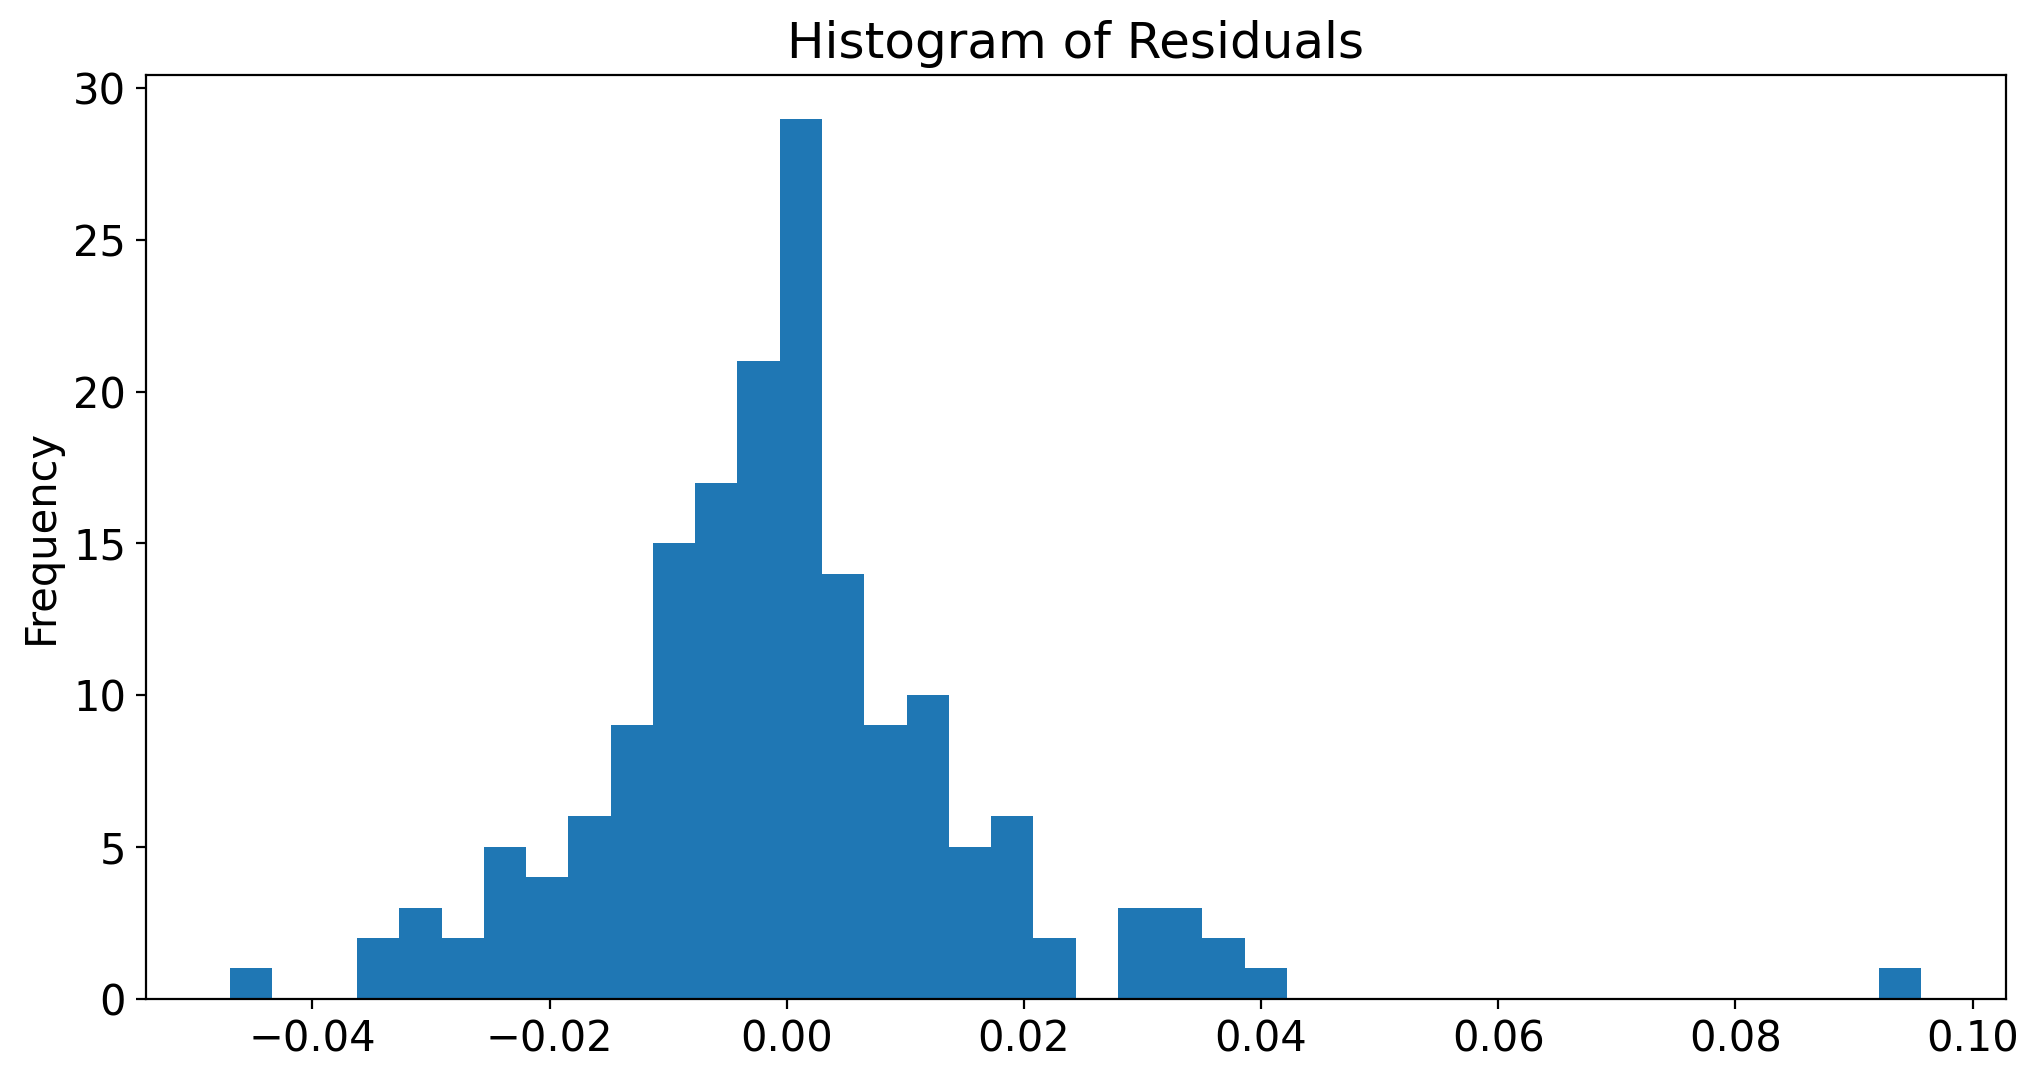

In [11]:
model.resid.plot(kind='hist', bins=40, title='Histogram of Residuals')
plt.show()

From a visual perspective, we can see our model does not violate all of these assumptions to an extreme degree.

Aside from just worrying about t-stats, we could ask whether the model is well-specified. 
* It seems to be stationary data
* We do not have a problem with multicolinearity

#### Another possible problem: Omitted variable bias. 
We may expect our estimates to be susceptible to omitted variables bias if we are missing certain variables, which in conjunction with t-stats can lead to false discoveries and interpretations.

***

# 2. Time-series Methods (30 pts)

### 2.1. (20pts) 

Forecast the next-month volatility of the return of $\targ$ using each of the following methods:
* expanding window (with minimum of 24 months)
* rolling window (24 months)
* GARCH(1,1)

The `expanding window` method is simply the standard deviation calculation using all data up to $t$ to predict variance or volatility at $t+1$. Using pandas, try `.expanding(24).std()`.

Be sure to annualize these volatility forecasts by scaling by $\sqrt{12}$.
* (a) Plot the time series of volatility forecasts using each of the three methods.

* (b) Report the volatility forecast for April 2020 (using data through March 2020) and May 2023 (using data through April 2023).

### 2.2 

Forecast $\targ$ with an autogression, using OLS. (That is, the regressor is a lag of the target.)

$$r^{\targ}_t = \alpha + \beta r^{\targ}_{t-1} + \epsilon_{t-1}$$

* (5pts) Report the r-squared and $\beta$ estimates.
* (5pts) Which of these issues would you expect to be a concern for this regression: 
    - non-stationary process
    - serial correlation
    
    No need to go into too much detail; a conceptual answer is fine.

***

# <span style='color:red'>Solution 2</span>

### <span style='color:red'>2.1</span>

In [12]:
FREQ = 12
WIN = 2

TARG_GARCH = 'HYG'
var_1 = .01

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


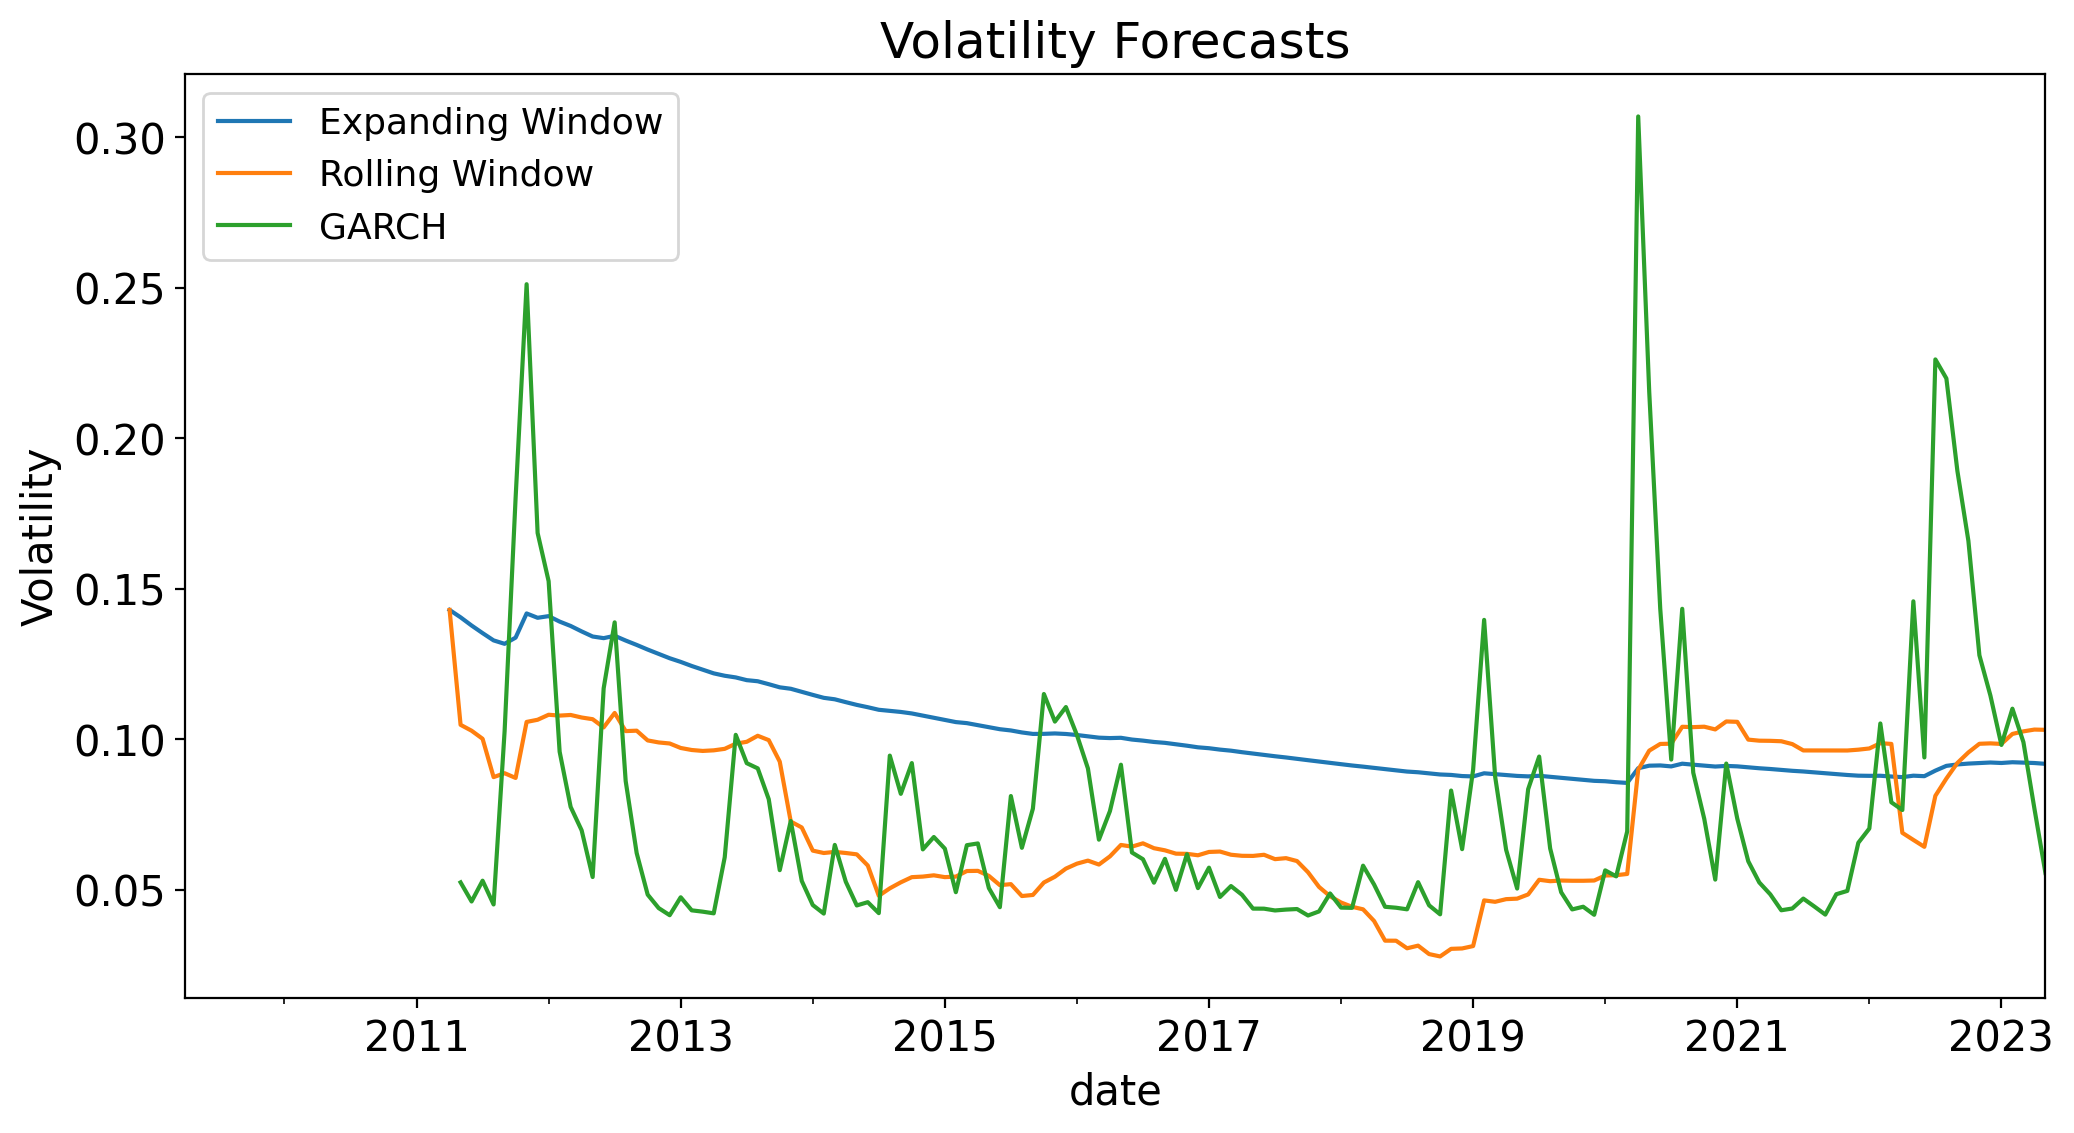

In [13]:
### Expanding Window
ygarch = rets[TARG_GARCH]
var = (ygarch**2).shift(1).expanding(min_periods=FREQ*WIN).mean().to_frame()
var.columns = ['Expanding Window']

### Rolling Window
var['Rolling Window'] = (ygarch**2).shift(1).rolling(WIN*FREQ).mean() 

SCALE = 100
yscld = ygarch * SCALE
GARCH = arch_model(yscld, vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit(disp='off')
garch_alt = GARCH_model.forecast(horizon=1,start=ygarch.index[FREQ*WIN],align='target').variance

var['GARCH'] = garch_alt / SCALE**2

### Convert variance to volatility
vol = (var * FREQ)**.5

vol.plot()
plt.title('Volatility Forecasts')
plt.ylabel('Volatility')
plt.show()

In [14]:
dts = ['2020-04-30','2023-05-31']
vol.loc[dts]

,Expanding Window,Rolling Window,GARCH
date,,,
2020-04-30,0.090401,0.089896,0.306928
2023-05-31,0.091862,0.103158,0.055616


### <span style='color:red'>2.2</span>

#### <span style='color:red'>(a)</span>

In [15]:
z = y.to_frame().shift().dropna()
z, pred = z.align(y,join='inner',axis=0)

mod = LinearRegression().fit(z,pred)

forecast_beta = mod.coef_
forecast_r2 = mod.score(z,pred)

In [16]:
pd.DataFrame([forecast_r2, forecast_beta[0]],index=['r-squared','beta']).style.format('{:.1%}')

,0
r-squared,3.9%
beta,-18.1%


#### <span style='color:red'>(b)</span>

* Stationarity should not be a concern, as the regression is in returns, not prices. Returns are stationary, (not trending up or down over time in a dramatic way.)

* Serial correlation would typically not be a large concern for returns. If there were obvious serial correlation in returns, then it would be easy to make money. However, in a lagged regression we do have reason to worry about serial correlation in the residual, $e$, even if not in the return, $r$. And as we learned in session 3.2, this type of serial correlation can cause inconsistency (bias even in large samples).

#### Not required
Below is the autocorrelation of the regression residuals and a plot. It indicates little serial correlation in the residuals.

'Autocorrelation in residuals from forecasting regression is -5.10%.'

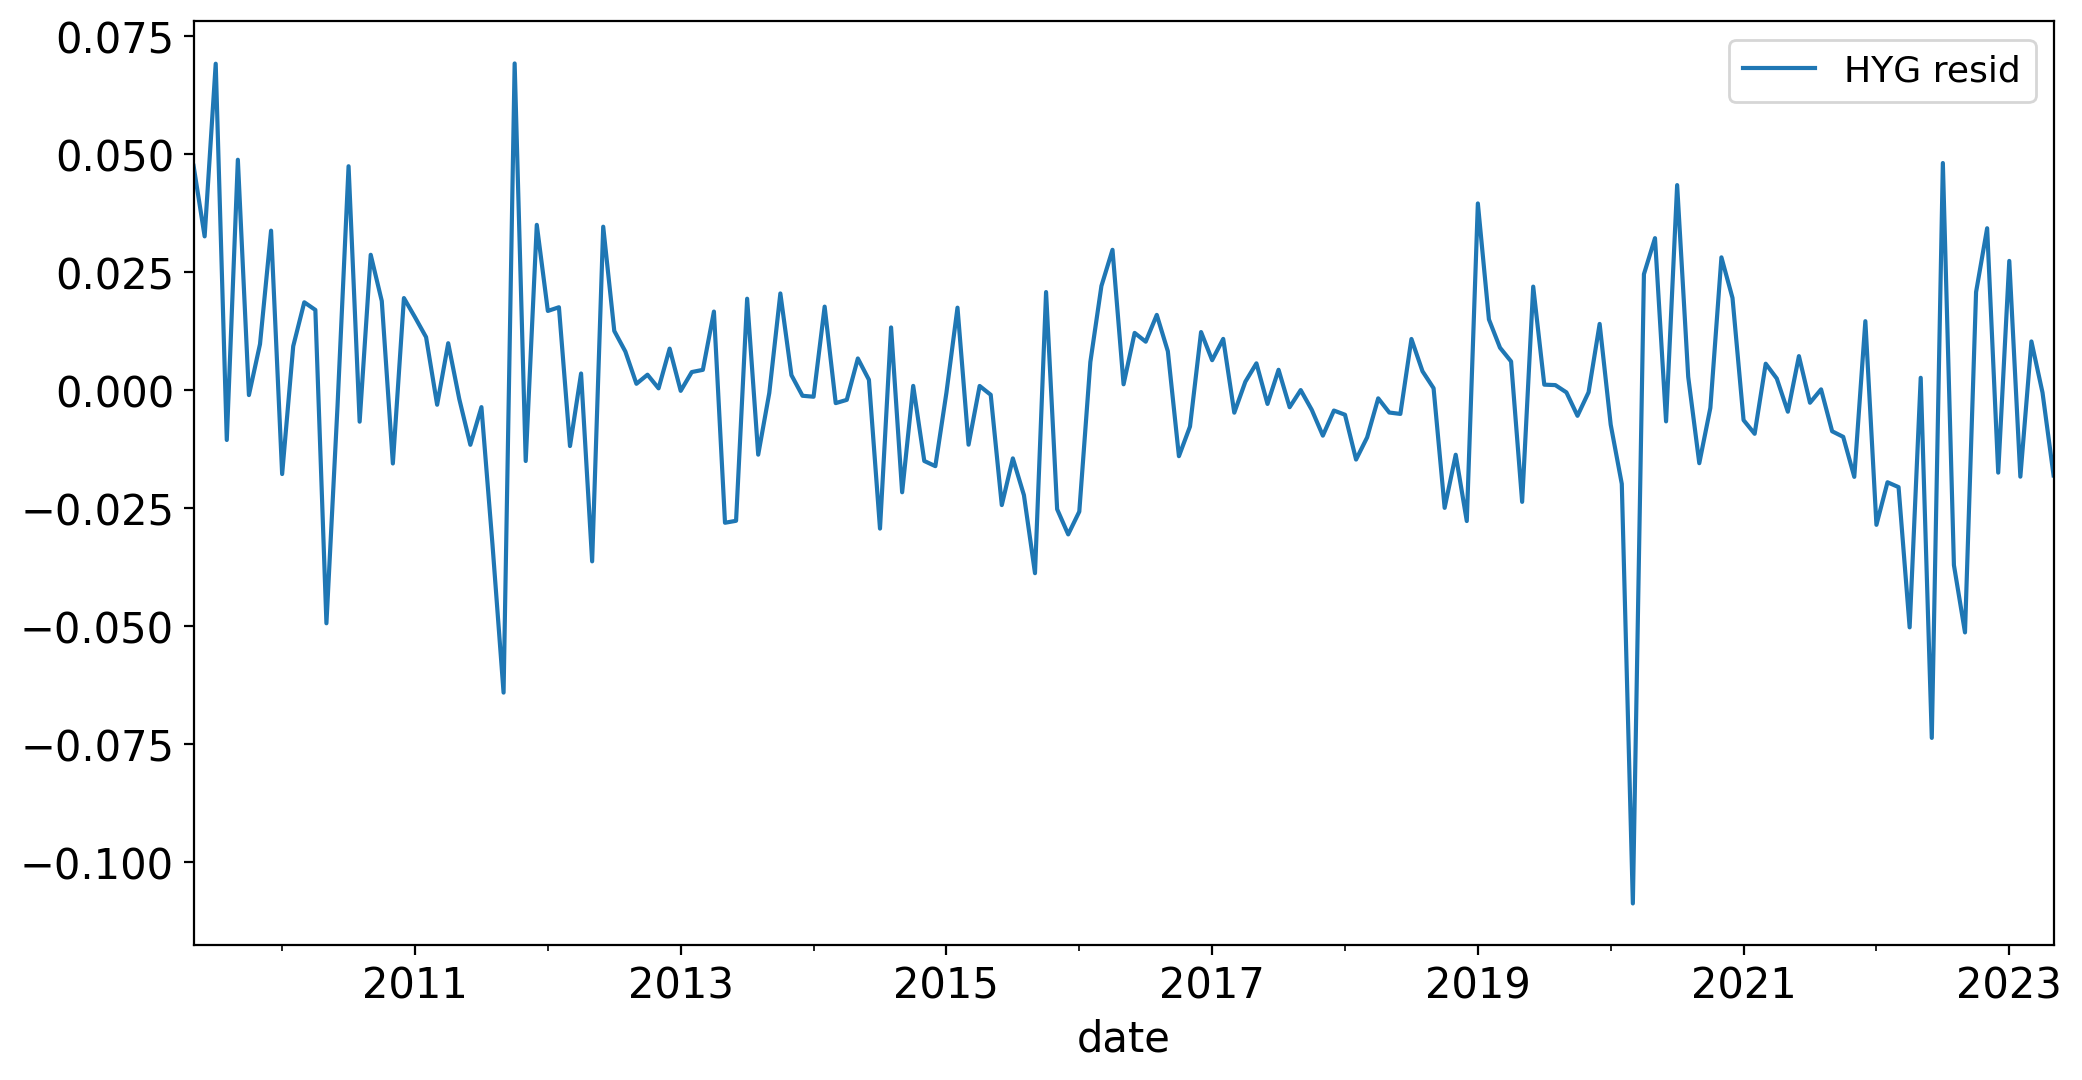

In [17]:
forecast_resids = (pred - mod.predict(z)).to_frame().rename(columns={'HYG':'HYG resid'})
rho = pd.concat([forecast_resids,forecast_resids.shift()],axis=1).corr().iloc[0,1]
display(f'Autocorrelation in residuals from forecasting regression is {rho:.2%}.')
forecast_resids.plot();

***

# 3. Penalized Regression (35pts)

Estimate the regression of $\targ$ on all 10 other return series. Use each of the following three models:
* OLS
* Ridge with penalty 0.5.
* LASSO with penalty 2e-4.

Only use data through the end of 2020.

### 3.1. (10pts) 
Report the estimated betas for each of the models.


### 3.2. (5pts) 
Report the regressor correlation matrix (10 × 10). What concerns does it raise about the estimation of the OLS model?

### 3.3. (5pts) 
How do the Ridge beta estimates above compare to OLS? Conceptually, what types of applications is Ridge useful?

### 3.4. (5pts) 
How do the LASSO beta estimates above compare to OLS? Conceptually, what types of applications is LASSO useful?

### 3.5. (10pts) 
Consider the out-of-sample fit (data for 2021 onward) for these three models. Report the r-squared for these out-of-sample estimates.

For example, try using `Ridge(alpha=PENALTY).fit(Xin).score(Xout)`.

***

# <span style='color:red'>Solution 3</span>

### <span style='color:red'>3.1</span>

In [18]:
PENALTY_ridge=5e-1
PENALTY_lasso = 2e-4

T = '2019'
T1 = '2020'

Xt = Xall[:T]
yt = y[:T]

reg = pd.DataFrame(index=list(Xt.columns)+['r-squared'], dtype=float)
reg['ols'] = estimate_reg(Xt,yt)
reg['ridge'] = estimate_reg(Xt,yt,model=Ridge,penalty=PENALTY_ridge)
reg['lasso'] = estimate_reg(Xt,yt,model=Lasso,penalty=PENALTY_lasso)

reg.style.format('{:.1%}')

,ols,ridge,lasso
SPY,-16.9%,3.7%,0.0%
EFA,-8.3%,4.5%,0.0%
EEM,4.1%,5.9%,4.6%
PSP,25.5%,7.8%,18.4%
QAI,41.6%,1.5%,0.0%
DBC,10.6%,3.7%,0.0%
IYR,19.4%,7.5%,9.6%
IEF,12.4%,-0.1%,0.0%
BWX,-3.7%,1.5%,0.0%
TIP,-20.7%,0.3%,0.0%


In [19]:
print(f'Size (L1) of beta estimates:\n{reg.iloc[:-1,:].abs().sum()}\n\n')
print(f'Number of non-zero beta estimates:\n{(reg.iloc[:-1,:].abs()>1e-6).sum()}')

Size (L1) of beta estimates:
ols      1.631051
ridge    0.365401
lasso    0.325574
dtype: float64


Number of non-zero beta estimates:
ols      10
ridge    10
lasso     3
dtype: int64


We see that ridge and lasso generally have smaller betas, many of which are 0 for lasso, which is to be expected.

### <span style='color:red'>3.2</span>

In [20]:
Xt.corr().style.format('{:.1%}')

,SPY,EFA,EEM,PSP,QAI,DBC,IYR,IEF,BWX,TIP
SPY,100.0%,86.7%,77.1%,88.0%,79.0%,53.2%,66.5%,-43.1%,34.7%,-2.6%
EFA,86.7%,100.0%,86.5%,90.4%,80.4%,58.5%,61.9%,-36.2%,55.3%,7.0%
EEM,77.1%,86.5%,100.0%,81.8%,78.9%,59.7%,59.5%,-27.3%,60.2%,18.9%
PSP,88.0%,90.4%,81.8%,100.0%,75.5%,50.1%,67.7%,-40.2%,43.0%,1.5%
QAI,79.0%,80.4%,78.9%,75.5%,100.0%,56.6%,53.0%,-10.0%,60.2%,28.0%
DBC,53.2%,58.5%,59.7%,50.1%,56.6%,100.0%,21.8%,-34.7%,44.4%,10.7%
IYR,66.5%,61.9%,59.5%,67.7%,53.0%,21.8%,100.0%,-1.8%,37.3%,22.0%
IEF,-43.1%,-36.2%,-27.3%,-40.2%,-10.0%,-34.7%,-1.8%,100.0%,26.4%,70.9%
BWX,34.7%,55.3%,60.2%,43.0%,60.2%,44.4%,37.3%,26.4%,100.0%,50.3%
TIP,-2.6%,7.0%,18.9%,1.5%,28.0%,10.7%,22.0%,70.9%,50.3%,100.0%


It is immediately apparent that the regressors are quite correlated, as financial data frequently is. From a regression standpoint, we should then be wary that our model may be distorted by multicollinearity, which can have the effect of making our model's estimates very sensitive to the data used to train it. As a result, our model is unlikely to have meaningful interpretation nor be predictive out of sample.

### <span style='color:red'>3.3</span>

Ridge estimates the betas to be smaller in magnitude, but still makes use of all of them, (all are nonzero.)

This is as expected, given Ridge's L2 penalty.

Ridge is useful in dealing with multicollinearity, particularly when we still believe that every regressor is useful/predictive. It allows us to make room for what the model deems to be the most "important" variables while still preserving the information granted to us by the other variables.

### <span style='color:red'>3.4</span>

The LASSO estimates are mostly zero, while those not zero show little penalty relative to OLS.

This is as expected given the L1 penalty of LASSO.

Note that QAI had the largest (in magnitude) beta for OLS, but was forced to zero with Lasso. That is because QAI was correlated with another regressor that was more useful. This leads LASSO to force QAI's beta to zero to "make room" for the other regressor. Another observation common to Lasso is that many of our betas are now zero.

LASSO is useful as a *dimensionality reduction* technique. Regardless of whether we want to simplify our model, or we believe that some regressors are either useless or redundant, Lasso helps us select a subset of regressors to use. As such, it is used in both prediction settings and when we are looking to make causal/associative discoveries. Similarly to ridge, it is also useful when dealing with multicollinearity.

### <span style='color:red'>3.5</span>

In [21]:
X_train = Xall[:T].copy()
y_train = y[:T].copy()
X_test = Xall[T1:].copy()
y_test = y[T1:].copy()

In [22]:
ols_train = LinearRegression().fit(X_train,y_train)
ridge_train = Ridge(alpha=PENALTY_ridge).fit(X_train,y_train)
lasso_train = Lasso(alpha=PENALTY_lasso).fit(X_train,y_train)

rsquared = pd.DataFrame(index=['ols','ridge','lasso'],columns=['in-sample','out-of-sample'],dtype=float)
rsquared['in-sample'] = reg.loc['r-squared']

rsquared['out-of-sample'] = [ols_train.score(X_test,y_test),                            
                           ridge_train.score(X_test,y_test),
                           lasso_train.score(X_test,y_test)]

rsquared.style.format('{:.1%}')

,in-sample,out-of-sample
ols,76.8%,63.0%
ridge,66.3%,68.2%
lasso,69.6%,71.8%


It is not surprising to find that the OOS r-squared degrades for OLS and holds up better for Ridge and LASSO, (and in this case actually improves.)